In [1]:
import pandas as pd
import numpy as np
from kagglehub import KaggleDatasetAdapter

d:\Anki\Masters\UMICH\Course Docs\Fall 2025\STATS507\project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [3]:
# Path to your parquet file
PATH = "data/all_stock_data.parquet"   # change to your actual path

prices = pd.read_parquet(PATH)

print(prices.head())# Ensure proper dtypes
prices.rename(columns={i:i.lower() for i in prices.columns}, inplace=True)
prices['date'] = pd.to_datetime(prices['date'])
prices['ticker'] = prices['ticker'].astype(str)

         Date Ticker  Open      High       Low     Close     Volume  \
0  1962-01-02     ED   0.0  0.265828  0.261788  0.261788    25600.0   
1  1962-01-02    CVX   0.0  0.046809  0.046069  0.046809   105840.0   
2  1962-01-02     GD   0.0  0.210033  0.203061  0.208290  2648000.0   
3  1962-01-02     BP   0.0  0.141439  0.139528  0.139528    77440.0   
4  1962-01-02    MSI   0.0  0.764923  0.745254  0.751810    65671.0   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  


In [4]:
print(prices.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34646258 entries, 0 to 34646257
Data columns (total 9 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   ticker        object        
 2   open          float64       
 3   high          float64       
 4   low           float64       
 5   close         float64       
 6   volume        float64       
 7   dividends     float64       
 8   stock splits  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 2.3+ GB
None


In [5]:
news_path = "C:\\Users\\reach\\.cache\\kagglehub\\datasets\\miguelaenlle\\massive-stock-news-analysis-db-for-nlpbacktests\\versions\\2"
analyst_processed = pd.read_csv(news_path+"\\analyst_ratings_processed.csv", parse_dates=["date"])
raw_partners = pd.read_csv(news_path+"\\raw_partner_headlines.csv", parse_dates=["date"])
raw_analyst = pd.read_csv(news_path+"\\raw_analyst_ratings.csv", parse_dates=["date"])

# rename columns to lowercase as functional programming step
analyst_processed.rename(columns={'stock':'ticker'}, inplace=True)
raw_partners.rename(columns={'stock':'ticker'}, inplace=True)
raw_analyst.rename(columns={'stock':'ticker'}, inplace=True)


In [6]:
print("Prices:",prices[prices.isna().sum(1)>0].size)
print("Analyst Processed:",analyst_processed[analyst_processed.isna().sum(1)>0].size)
print("",raw_partners[raw_partners.isna().sum(1)>0].size)
print(raw_analyst[raw_analyst.isna().sum(1)>0].size)

prices.dropna(inplace=True,how='any')
analyst_processed.dropna(inplace=True,how='any')
raw_partners.dropna(inplace=True,how='any')
raw_analyst.dropna(inplace=True,how='any')


Prices: 981
Analyst Processed: 10312
 0
0


In [7]:
def print_unique_tickers():
    print("Unique tickers:")
    DFs = {"prices":prices, "analyst_processed":analyst_processed, "raw_partners":raw_partners, "raw_analyst":raw_analyst}
    for temp in DFs:
        print(f"{temp}",DFs[temp]['ticker'].nunique(),sep=" : ")

print_unique_tickers()

# Combine all unique tickers from news datasets
news_tickers = pd.Series(
    pd.concat([
        analyst_processed['ticker'],
        raw_partners['ticker'],
        raw_analyst['ticker']
    ]).unique()
)

print("Tickers in news datasets:", len(news_tickers))
# common tickers
common_tickers = np.intersect1d(prices['ticker'].unique(), news_tickers)
print("Common tickers between prices and news datasets:", len(common_tickers))

Unique tickers:
prices : 9315
analyst_processed : 6192
raw_partners : 6552
raw_analyst : 6204
Tickers in news datasets: 6628
Common tickers between prices and news datasets: 2740


In [8]:
%%skip
analyst_processed.head() # 2020-06-05 10:30:00-04:00
raw_partners.head() # 2020-06-01	
raw_analyst.head() # 2020-06-05 10:30:54-04:00

print(raw_analyst['date'].head(1), analyst_processed['date'].head(1), raw_partners['date'].head(1))


In [9]:
%%skip

import re
import pandas as pd

def find_timezone_offsets(df, date_col='date'):
    """
    Scans the date column and detects any timezone offsets of the form ±HH:MM.
    Returns a set of unique offsets.
    """
    tz_regex = re.compile(r'([+-]\d{2}:\d{2})$')

    offsets = set()

    for val in df[date_col].astype(str):
        match = tz_regex.search(val.strip())
        if match:
            offsets.add(match.group(1))

    return offsets

find_timezone_offsets(raw_analyst, 'date'), find_timezone_offsets(analyst_processed, 'date'), find_timezone_offsets(raw_partners, 'date')

In [10]:
import pandas as pd
import re

def clean_datetime_column(df, date_col):
    """
    Removes timezone offsets like -04:00 or +01:00,
    handles date-only strings, and outputs clean parseable timestamps.
    """
    tz_pattern = re.compile(r'([+-]\d{2}:\d{2})$')

    def strip_tz(x):
        if pd.isna(x):
            return x
        x = str(x).strip()
        # Remove timezone suffix
        x = tz_pattern.sub('', x)
        return x

    df = df.copy()
    df[date_col] = df[date_col].apply(strip_tz)
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    return df

def normalize_news_candidate_date(news_df, date_col='date', has_time=True, market_close_hour=16):
    df = news_df.copy()
    # Localize naive timestamps to America/New_York (they represent local times)
    df['_local'] = df[date_col].dt.tz_localize('America/New_York', ambiguous='NaT', nonexistent='NaT')

    if has_time:
        df['_local_date'] = df['_local'].dt.normalize().dt.tz_localize(None)
        df['_local_hour'] = df['_local'].dt.hour

        # After-hours → next calendar day
        df['candidate_date'] = (
            df['_local_date'] +
            pd.to_timedelta((df['_local_hour'] >= market_close_hour).astype(int), unit='D')
        )
    else:
        # Day-only data → assigned to next day
        df['candidate_date'] = df[date_col].dt.normalize()

    df['candidate_date'] = pd.to_datetime(df['candidate_date']).dt.normalize()

    return df.drop(columns=['_local', '_local_date', '_local_hour'], errors='ignore')

def preprocess_news_frames(raw_analyst=None, analyst_processed=None, raw_partners=None):
    news_cleaned = []

    for df, has_time in [
        (raw_analyst, True),
        (analyst_processed, True),
        (raw_partners, False)
    ]:
        if df is None:
            continue

        # df = df.copy()

        # --- Step 1: Clean datetime ---
        df = clean_datetime_column(df, 'date')

        # Remove rows with null dates after parsing
        df = df.dropna(subset=['date'])

        # --- Step 2: Normalize to candidate trading date ---
        df = normalize_news_candidate_date(df, date_col='date', has_time=has_time)

        news_cleaned.append(df)

    return news_cleaned
raw_analyst, analyst_processed, raw_partners = preprocess_news_frames(raw_analyst, analyst_processed, raw_partners)
raw_analyst.info(), analyst_processed.info(), raw_partners.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   Unnamed: 0      1407328 non-null  int64         
 1   headline        1407328 non-null  object        
 2   url             1407328 non-null  object        
 3   publisher       1407328 non-null  object        
 4   date            1407328 non-null  datetime64[ns]
 5   ticker          1407328 non-null  object        
 6   candidate_date  1407328 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 75.2+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 1397891 entries, 0 to 1400468
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   Unnamed: 0      1397891 non-null  float64       
 1   title           1397891 non-null  object        
 2   date

(None, None, None)

In [11]:
# %%skip
# Consider only prices for tickers present in raw_partners
prices[prices['ticker'].isin(raw_partners['ticker'].unique())]

,date,ticker,open,high,low,close,volume,dividends,stock splits
0,1962-01-02,ED,0.000000,0.265828,0.261788,0.261788,25600.0,0.0,0.0
2,1962-01-02,GD,0.000000,0.210033,0.203061,0.208290,2648000.0,0.0,0.0
3,1962-01-02,BP,0.000000,0.141439,0.139528,0.139528,77440.0,0.0,0.0
4,1962-01-02,MSI,0.000000,0.764923,0.745254,0.751810,65671.0,0.0,0.0
6,1962-01-02,FL,0.000000,0.972249,0.953806,0.959075,49200.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
34646249,2024-11-04,ARAY,1.750000,1.750000,1.735000,1.735000,41888.0,0.0,0.0
34646252,2024-11-04,GDO,11.880000,11.920000,11.920000,11.920000,1398.0,0.0,0.0
34646253,2024-11-04,NEOG,14.490000,14.580000,14.340000,14.345000,18972.0,0.0,0.0
34646256,2024-11-04,NNN,43.730000,43.439999,43.209999,43.244999,88675.0,0.0,0.0


In [12]:
import pandas as pd

def drop_nulls(*dfs):
    return [df.dropna().copy() for df in dfs]


def get_all_news_info(news_dfs):
    all_news = pd.concat(news_dfs, ignore_index=True)

    tickers_with_news = set(all_news['ticker'].unique())
    earliest_news_date = all_news['date'].min()

    news_dates_by_ticker = (
        all_news.groupby('ticker')['date'].apply(list).to_dict()
    )

    return tickers_with_news, earliest_news_date, news_dates_by_ticker


def filter_prices(prices, tickers_with_news, earliest_news_date, news_dates_by_ticker):
    prices = prices.copy()
    prices['date'] = pd.to_datetime(prices['date'])

    # 1. Remove tickers with zero news
    prices = prices[prices['ticker'].isin(tickers_with_news)]

    # 2. Remove early price rows (unless the ticker has future news)
    def keep_row(row):
        ticker = row['ticker']
        date = row['date']

        if date >= earliest_news_date:
            return True

        future_news_dates = news_dates_by_ticker.get(ticker, [])
        return any(d > date for d in future_news_dates)

    return prices[prices.apply(keep_row, axis=1)]


def preprocess(prices, raw_analyst, analyst_processed, raw_partners):
    """
    - Drop nulls
    - Remove tickers with no news
    - Remove price rows too early unless future news exists
    """
    # # Step 1: Drop full-null rows for safety
    prices, raw_analyst, analyst_processed, raw_partners = drop_nulls(
        prices, raw_analyst, analyst_processed, raw_partners
    )

    # Step 2: Get news metadata
    tickers_with_news, earliest_news_date, news_dates_by_ticker = get_all_news_info([raw_analyst, analyst_processed, raw_partners])

    # Step 4: Filter prices
    print("Prices before preprocessing:", prices.shape)
    prices = filter_prices(prices, tickers_with_news, earliest_news_date, news_dates_by_ticker)
    
    return prices

prices = preprocess(prices, raw_analyst, analyst_processed, raw_partners)
print("Prices after preprocessing:", prices.shape)

Prices before preprocessing: (34646149, 9)
Prices after preprocessing: (18149852, 9)


In [13]:
print_unique_tickers()

Unique tickers:
prices : 2740
analyst_processed : 6192
raw_partners : 6552
raw_analyst : 6204


In [14]:
%%skip
def normalize_news_candidate_date(news_df, date_col='date', has_time=True, market_close_hour=16):
    df = news_df.copy()
    # parse datetimes with utc=True to avoid mixed timezone issues; results are tz-aware (UTC)
    df['_ts'] = pd.to_datetime(df[date_col], utc=True, errors='coerce')
    if has_time:
        # convert UTC timestamps to US/Eastern and extract local date/hour
        df['_local'] = df['_ts'].dt.tz_convert('America/New_York')
        df['_local_date'] = df['_local'].dt.normalize().dt.tz_localize(None)
        df['_local_hour'] = df['_local'].dt.hour
        df['candidate_date'] = df['_local_date'] + pd.to_timedelta((df['_local_hour'] >= market_close_hour).astype(int), unit='D')
    else:
        parsed = pd.to_datetime(df[date_col], errors='coerce')
        df['candidate_date'] = parsed.dt.normalize() + pd.Timedelta(days=1)
    df['candidate_date'] = pd.to_datetime(df['candidate_date']).dt.normalize()
    return df.drop(columns=['_ts','_local','_local_date','_local_hour'], errors='ignore')

temp = normalize_news_candidate_date(analyst_processed)
temp.sort_values(by=['date'], ascending=False).head(10)

# Get the rows where the 'date' column has values not according to format YYYY-MM-DD
def remove_na(df):
    pattern1 = r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}[+-]\d{2}:\d{2}$'
    pattern2 = r'^\d{4}-\d{2}-\d{2}$'
    valid_rows_1 = df['date'].astype(str).str.match(pattern1)
    valid_rows_2 = df['date'].astype(str).str.match(pattern2)
    if valid_rows_1.any():
        print(valid_rows_1.shape)
        print("Pattern 1 matched rows exist. Invalid rows based on pattern 1:")
        invalid_rows = df[~valid_rows_1]
    elif valid_rows_2.any():
        print("Pattern 2 matched rows exist. Invalid rows based on pattern 2:")
        invalid_rows = df[~valid_rows_2]
    else:
        print("No valid patterns matched.")
        invalid_rows = df
    
    print(invalid_rows.head(), len(invalid_rows),sep='\n')
# remove_na(analyst_processed)
# remove_na(raw_partners)
remove_na(raw_analyst)

# analyst_processed.head().sort_values(by=['date'], ascending=True)

In [15]:
# Functions to normalize news timestamps, map to trading days, aggregate, and merge
def prepare_stock_df(stock_df):
    stock_df = stock_df.copy()
    stock_df['date'] = pd.to_datetime(stock_df['date'])
    stock_df = stock_df.sort_values(['ticker','date']).reset_index(drop=True)
    return stock_df

def build_trading_days_map(stock_df):
    grouped = stock_df.groupby('ticker')['date'].unique()
    trading_map = {}
    for ticker, dates in grouped.items():
        arr = np.sort(np.array(pd.to_datetime(dates).astype('datetime64[ns]')))
        trading_map[ticker] = arr
    return trading_map

def normalize_news_candidate_date(news_df, date_col='date', has_time=True, market_close_hour=16):
    df = news_df.copy()
    # parse datetimes with utc=True to avoid mixed timezone issues; results are tz-aware (UTC)
    df['_ts'] = pd.to_datetime(df[date_col], utc=True, errors='coerce')
    if has_time:
        # convert UTC timestamps to US/Eastern and extract local date/hour
        df['_local'] = df['_ts'].dt.tz_convert('America/New_York')
        df['_local_date'] = df['_local'].dt.normalize().dt.tz_localize(None)
        df['_local_hour'] = df['_local'].dt.hour
        df['candidate_date'] = df['_local_date'] + pd.to_timedelta((df['_local_hour'] >= market_close_hour).astype(int), unit='D')
    else:
        parsed = pd.to_datetime(df[date_col], errors='coerce')
        df['candidate_date'] = parsed.dt.normalize() + pd.Timedelta(days=1)
    df['candidate_date'] = pd.to_datetime(df['candidate_date']).dt.normalize()
    return df.drop(columns=['_ts','_local','_local_date','_local_hour'], errors='ignore')

def map_to_next_trading_day(news_df, trading_map, ticker_col='ticker'):
    df = news_df.copy()
    def find_match(row):
        t = row.get(ticker_col)
        cd = row['candidate_date']
        if pd.isna(cd) or t not in trading_map:
            return pd.NaT
        arr = trading_map[t]
        idx = np.searchsorted(arr, np.datetime64(cd), side='left')
        if idx >= len(arr):
            return pd.NaT
        return pd.to_datetime(arr[idx])
    df['trading_date'] = df.apply(find_match, axis=1)
    return df

def aggregate_news_features(mapped_news_df, ticker_col='ticker', text_col_candidates=('title','headline'), publisher_col='publisher'):
    """Aggregate mapped news per (ticker, trading_date).

    Returns a dataframe with:
      - ticker, trading_date
      - news_count, unique_publishers, avg_text_len
      - combined_text: concatenated headlines/titles (for downstream NLP)
    """
    df = mapped_news_df.copy()
    df = df.dropna(subset=['trading_date'])
    # choose text column (prefer 'title' then 'headline')
    text_col = next((c for c in text_col_candidates if c in df.columns), None)
    if text_col is None:
        df['text'] = ''
    else:
        df['text'] = df[text_col].fillna('').astype(str)
    # text length
    df['text_len'] = df['text'].str.len()
    # publisher handling
    if publisher_col in df.columns:
        df[publisher_col] = df[publisher_col].fillna('unknown')
    # aggregate: counts, unique publishers, avg length, and combined text
    agg = df.groupby([ticker_col, 'trading_date']).agg(
        news_count = ('text', 'count'),
        unique_publishers = (publisher_col if publisher_col in df.columns else 'text', lambda x: x.nunique() if publisher_col in df.columns else 0),
        avg_text_len = ('text_len', 'mean'),
        combined_text = ('text', lambda s: ' '.join(s.values.astype(str)))
    ).reset_index().rename(columns={ticker_col: 'ticker'})
    # clip extremely long combined text to avoid memory blowups when previewing
    agg['combined_text'] = agg['combined_text'].astype(str).str.slice(0, 200000)
    agg['unique_publishers'] = agg['unique_publishers'].fillna(0).astype(int)
    agg['avg_text_len'] = agg['avg_text_len'].fillna(0.0)
    return agg

# Run the pipeline using variables already present in the notebook: `prices`, `analyst_processed`, `raw_partners`, `raw_analyst`
prices = prepare_stock_df(prices)
trading_map = build_trading_days_map(prices)
# Ensure newsframes have 'ticker' and 'date' columns
for df_name in ['analyst_processed','raw_partners','raw_analyst']:
    if df_name in globals():
        df = globals()[df_name]
        if 'ticker' not in df.columns and 'stock' in df.columns:
            df.rename(columns={'stock':'ticker'}, inplace=True)
            
# Process datasets: analyst_processed and raw_analyst have timestamps, raw_partners is day-only
news_list = []
if 'analyst_processed' in globals():
    n1 = analyst_processed
    n1 = map_to_next_trading_day(n1, trading_map, ticker_col='ticker')
    news_list.append(n1)
if 'raw_analyst' in globals():
    n2 = raw_analyst
    n2 = map_to_next_trading_day(n2, trading_map, ticker_col='ticker')
    news_list.append(n2)
if 'raw_partners' in globals():
    n3 = raw_partners
    n3 = map_to_next_trading_day(n3, trading_map, ticker_col='ticker')
    news_list.append(n3)

combined_news = pd.concat(news_list, ignore_index=True, sort=False) if news_list else pd.DataFrame()
# Aggregate news features including concatenated text
news_agg = aggregate_news_features(combined_news, ticker_col='ticker', text_col_candidates=('title','headline'), publisher_col='publisher')
# Keep a day-level news table with raw items for later NLP if needed
news_by_day = news_agg.rename(columns={'trading_date':'date'})
    

In [16]:
def merge_stock_news(stock_df, news_agg_df):
    df_stock = stock_df.copy()
    df_stock = df_stock.rename(columns={'date':'date_stock'})
    news = news_agg_df.rename(columns={'trading_date':'date_stock'})
    merged = df_stock.merge(news, on=['ticker','date_stock'], how='left')
    merged = merged.rename(columns={'date_stock':'date'})
    merged['news_count'] = merged.get('news_count',0).fillna(0).astype(int)
    merged['unique_publishers'] = merged.get('unique_publishers',0).fillna(0).astype(int)
    merged['avg_text_len'] = merged.get('avg_text_len',0.0).fillna(0.0)
    # ensure combined_text exists (empty string when missing)
    if 'combined_text' in merged.columns:
        merged['combined_text'] = merged['combined_text'].fillna('')
    else:
        merged['combined_text'] = ''
    return merged

def add_future_return_label(stock_with_news, horizon=1):
    df = stock_with_news.copy()
    df = df.sort_values(['ticker','date'])
    def compute_group(g):
        g = g.copy()
        g[f'future_return_{horizon}'] = (g['close'].shift(-horizon) - g['close']) / g['close']
        g[f'future_direction_{horizon}'] = (g[f'future_return_{horizon}'] > 0).astype(int)
        return g
    out = df.groupby('ticker').apply(compute_group).reset_index(drop=True)
    return out

# write a quick sample to disk (uncomment to save)
# news_by_day.to_parquet('news_by_day.parquet', index=False)
# Merge with stock data (news_agg contains combined_text)
merged = merge_stock_news(prices, news_agg)
merged_with_label = add_future_return_label(merged, horizon=1)
display_cols = ['date','ticker','close','news_count','unique_publishers','avg_text_len','combined_text','future_return_1']
print(merged_with_label[display_cols].head(20))

# Filter to only stock rows that have news (either count>0 or non-empty combined_text)
merged_with_news = merged_with_label[(merged_with_label['news_count'] > 0) | (merged_with_label['combined_text'].str.strip() != '')].copy()
print('Rows with news:', len(merged_with_news))

display_cols_news = ['date','ticker','close','news_count','unique_publishers','avg_text_len','combined_text','future_return_1']
merged_with_news[display_cols_news].head(20)

C:\Users\reach\AppData\Local\Temp\ipykernel_35744\564143248.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = df.groupby('ticker').apply(compute_group).reset_index(drop=True)


         date ticker      close  news_count  unique_publishers  avg_text_len  \
0  1999-11-18      A  27.066582           0                  0           0.0   
1  1999-11-19      A  24.836662           0                  0           0.0   
2  1999-11-22      A  27.066582           0                  0           0.0   
3  1999-11-23      A  24.605980           0                  0           0.0   
4  1999-11-24      A  25.259573           0                  0           0.0   
5  1999-11-26      A  25.336472           0                  0           0.0   
6  1999-11-29      A  25.913176           0                  0           0.0   
7  1999-11-30      A  25.951620           0                  0           0.0   
8  1999-12-01      A  26.412981           0                  0           0.0   
9  1999-12-02      A  27.143471           0                  0           0.0   
10 1999-12-03      A  27.374151           0                  0           0.0   
11 1999-12-06      A  28.143091         

,date,ticker,close,news_count,unique_publishers,avg_text_len,combined_text,future_return_1
2373,2009-04-29,A,11.771303,2,2,11.000000,Going Against the Herd,0.012757
2395,2009-06-01,A,12.326245,1,1,0.000000,,0.035487
2396,2009-06-02,A,12.763672,1,1,62.000000,super-trades - Two 52 week highs and others ab...,-0.011253
2425,2009-07-14,A,12.724497,2,2,38.000000,Skystar Bio-Pharmaceutical Announces Expansion...,0.054900
2437,2009-07-30,A,15.120544,1,1,0.000000,,0.002590
2438,2009-07-31,A,15.159713,1,1,49.000000,The Gold/Silver Ratio From 1300 to 1900...And Now,0.031439
2440,2009-08-04,A,15.779943,2,2,33.500000,"A Simulation of China's 2,$$$,$$$,$$$,$$$ Dive...",-0.026479
2442,2009-08-06,A,15.192357,8,3,5.125000,SRS Class Action Lawsuit filed 08/05/2009,0.019768
2443,2009-08-07,A,15.492681,155,2,37.851613,C.A. Bancorp Inc. Reports Second Quarter 2009 ...,0.004214
2444,2009-08-10,A,15.557970,284,4,35.630282,Gulfside Announces Non-Brokered Private Placem...,0.002518


Total rows (days with news): 1053371
Unique tickers with news: 2740
date range: 2009-04-27 00:00:00 -> 2024-10-24 00:00:00

Top 20 tickers by total news_count:
ticker
GILD    7943
HD      7070
FDX     7029
KR      6920
MRK     6669
MS      6488
FCX     6458
MDT     6402
MU      6293
GRPN    6285
NVDA    6279
QQQ     6206
JWN     6161
M       6107
EA      6104
EBAY    6047
WDC     6043
NFLX    6037
LLY     5939
VZ      5909
Name: news_count, dtype: int64


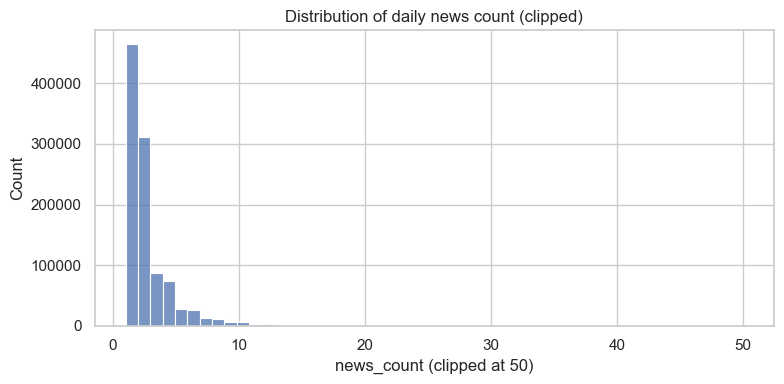

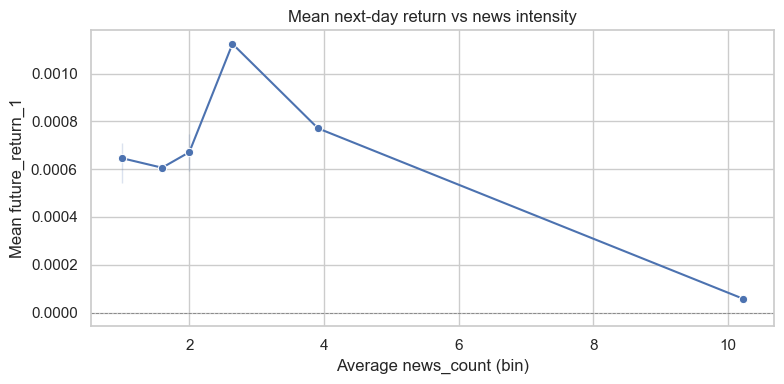


Sample ticker for time-series: GILD


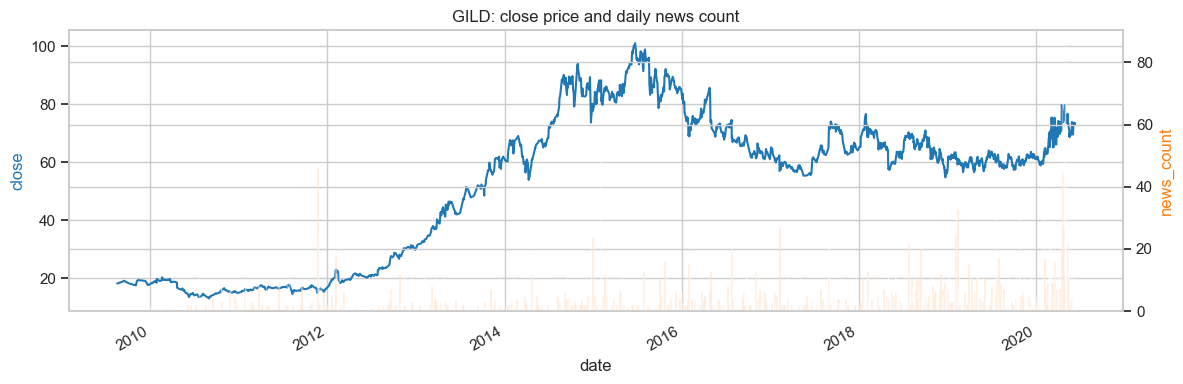


Summary (dict): {'total_rows_with_news': 1053371, 'unique_tickers_with_news': 2740, 'top_tickers_by_news': {'GILD': 7943, 'HD': 7070, 'FDX': 7029, 'KR': 6920, 'MRK': 6669, 'MS': 6488, 'FCX': 6458, 'MDT': 6402, 'MU': 6293, 'GRPN': 6285}}


In [17]:
# Analysis and visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Safety checks
if 'merged_with_news' not in globals():
    raise RuntimeError('`merged_with_news` not found - run previous cells to produce it')
df = merged_with_news.copy()
# Basic summary
print('Total rows (days with news):', len(df))
print('Unique tickers with news:', df['ticker'].nunique())
print('date range:', df['date'].min(), '->', df['date'].max())

# Convert date to datetime if needed
df['date'] = pd.to_datetime(df['date'])

# Top tickers by total news volume
top_by_news = df.groupby('ticker')['news_count'].sum().sort_values(ascending=False).head(20)
print('\nTop 20 tickers by total news_count:')
print(top_by_news)

# Histogram of news_count per (ticker,date)
plt.figure(figsize=(8,4))
sns.histplot(df['news_count'].clip(upper=50), bins=50, kde=False)
plt.xlabel('news_count (clipped at 50)')
plt.title('Distribution of daily news count (clipped)')
plt.tight_layout()
plt.show()

# Relationship: news intensity vs next-day mean return
# Creating quantile bins of daily news_count
df['news_q'] = pd.qcut(df['news_count'].rank(method='first'), q=10, labels=False, duplicates='drop')
grp = df.groupby('news_q').agg(avg_news_count=('news_count','mean'), mean_future_return=('future_return_1','mean'), n=('ticker','count')).reset_index()

plt.figure(figsize=(8,4))
ax = sns.lineplot(data=grp, x='avg_news_count', y='mean_future_return', marker='o')
ax.set_xlabel('Average news_count (bin)')
ax.set_ylabel('Mean future_return_1')
ax.set_title('Mean next-day return vs news intensity')
plt.axhline(0, color='gray', linewidth=0.6, linestyle='--')
plt.tight_layout()
plt.show()

# Time-series example: choose the top ticker by news and plot close + news_count
if len(top_by_news) > 0:
    sample_ticker = top_by_news.index[0]
    print('\nSample ticker for time-series:', sample_ticker)
    df_t = df[df['ticker'] == sample_ticker].sort_values('date')
    fig, ax1 = plt.subplots(figsize=(12,4))
    ax2 = ax1.twinx()
    ax1.plot(df_t['date'], df_t['close'], color='tab:blue', label='close')
    ax2.bar(df_t['date'], df_t['news_count'], color='tab:orange', alpha=0.4, label='news_count')
    ax1.set_xlabel('date')
    ax1.set_ylabel('close', color='tab:blue')
    ax2.set_ylabel('news_count', color='tab:orange')
    plt.title(f'{sample_ticker}: close price and daily news count')
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()
else:
    print('No tickers available to plot time-series')

# Word cloud suggestion (commented): if you want a quick wordcloud of combined_text for the top ticker, install wordcloud and uncomment below
# from wordcloud import WordCloud
# text = ' '.join(df[df['ticker']==sample_ticker]['combined_text'].fillna('').astype(str).values)
# wc = WordCloud(width=800, height=400, max_words=200).generate(text)
# plt.figure(figsize=(10,4)); plt.imshow(wc, interpolation='bilinear'); plt.axis('off'); plt.show()

# Save small summary to disk (optional)
summary = {
    'total_rows_with_news': len(df),
    'unique_tickers_with_news': int(df['ticker'].nunique()),
    'top_tickers_by_news': top_by_news.head(10).to_dict()
}
print('\nSummary (dict):', summary)

Top 20 tickers by total news_count:
ticker
GILD    7943
HD      7070
FDX     7029
KR      6920
MRK     6669
MS      6488
FCX     6458
MDT     6402
MU      6293
GRPN    6285
NVDA    6279
QQQ     6206
JWN     6161
M       6107
EA      6104
EBAY    6047
WDC     6043
NFLX    6037
LLY     5939
VZ      5909
Name: news_count, dtype: int64


,total_news,days_with_news,avg_daily_news,mean_future_return,win_rate,avg_volume,vol_future_return
ticker,,,,,,,
GILD,7943,1588,5.001889,0.000904,0.534635,NaN,0.019442
HD,7070,1498,4.719626,0.001275,0.536048,NaN,0.015236
FDX,7029,1425,4.932632,0.000469,0.527018,NaN,0.019765
KR,6920,1809,3.825318,0.000817,0.535655,NaN,0.017567
MRK,6669,1605,4.155140,0.000759,0.518380,NaN,0.013505
MS,6488,1447,4.483760,0.000438,0.498963,NaN,0.025992
FCX,6458,1757,3.675583,0.000232,0.492316,NaN,0.035009
MDT,6402,1704,3.757042,0.000406,0.523474,NaN,0.015132
MU,6293,1238,5.083199,0.000733,0.510501,NaN,0.033301


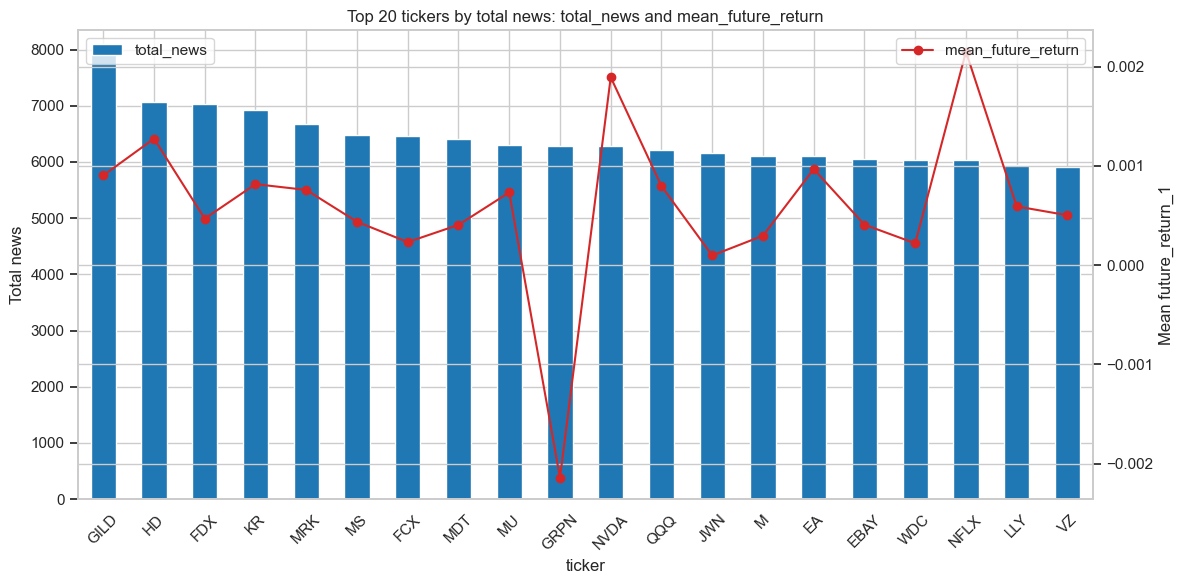

In [18]:
# %%skip
# Top-20 stocks by news: summary statistics and visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

if 'merged_with_news' not in globals():
    raise RuntimeError('`merged_with_news` not found - run previous cells to produce it')
df = merged_with_news.copy()
# Ensure numeric cols exist
if 'news_count' not in df.columns:
    df['news_count'] = 0
# compute top 20 tickers by total news_count
top20 = df.groupby('ticker')['news_count'].sum().nlargest(20)
top20_list = top20.index.tolist()
print('Top 20 tickers by total news_count:')
print(top20)

rows = []
for t in top20_list:
    g = df[df['ticker'] == t]
    total_news = int(g['news_count'].sum())
    days_with_news = len(g)
    avg_daily_news = float(g['news_count'].mean()) if days_with_news>0 else 0.0
    mean_future_return = float(g['future_return_1'].mean()) if 'future_return_1' in g.columns else float('nan')
    win_rate = float(g['future_direction_1'].mean()) if 'future_direction_1' in g.columns else float('nan')
    avg_volume = float(g['Volume'].mean()) if 'Volume' in g.columns else float('nan')
    vol_future = float(g['future_return_1'].std()) if 'future_return_1' in g.columns else float('nan')
    rows.append({
        'ticker': t,
        'total_news': total_news,
        'days_with_news': days_with_news,
        'avg_daily_news': avg_daily_news,
        'mean_future_return': mean_future_return,
        'win_rate': win_rate,
        'avg_volume': avg_volume,
        'vol_future_return': vol_future,
    })
summary_df = pd.DataFrame(rows).set_index('ticker')
# display sorted by total_news
summary_df = summary_df.sort_values('total_news', ascending=False)
display(summary_df)

# Plot total_news (bar) and mean_future_return (line)
fig, ax = plt.subplots(figsize=(12,6))
summary_df['total_news'].plot(kind='bar', color='tab:blue', ax=ax)
ax.set_ylabel('Total news')
ax.set_xlabel('ticker')
ax.tick_params(axis='x', rotation=45)
ax2 = ax.twinx()
summary_df['mean_future_return'].plot(kind='line', marker='o', color='tab:red', ax=ax2)
ax2.set_ylabel('Mean future_return_1')
ax.set_title('Top 20 tickers by total news: total_news and mean_future_return')
ax.legend(['total_news'], loc='upper left')
ax2.legend(['mean_future_return'], loc='upper right')
plt.tight_layout()
plt.show()

# Save summary to disk (optional)
# summary_df.to_csv('top20_news_stats.csv')

In [19]:
# Save the merged dataset with news features to a parquet file
merged_with_news.to_parquet('data\merged_market_with_news.parquet', index=False)

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\reach\AppData\Local\Temp\ipykernel_35744\1021043592.py:2: SyntaxWarning: invalid escape sequence '\m'
  merged_with_news.to_parquet('data\merged_market_with_news.parquet', index=False)


Prepared feature dataframe rows: 1027145
Train rows: 719083 Test rows: 308062
--- Market-only (LogReg) ---
Accuracy: 0.513
Precision: 0.5131
Recall: 0.814
F1: 0.6294
ROC AUC: 0.5139
--- Market+News (LogReg) ---
Accuracy: 0.5136
Precision: 0.5142
Recall: 0.7762
F1: 0.6186
ROC AUC: 0.5141


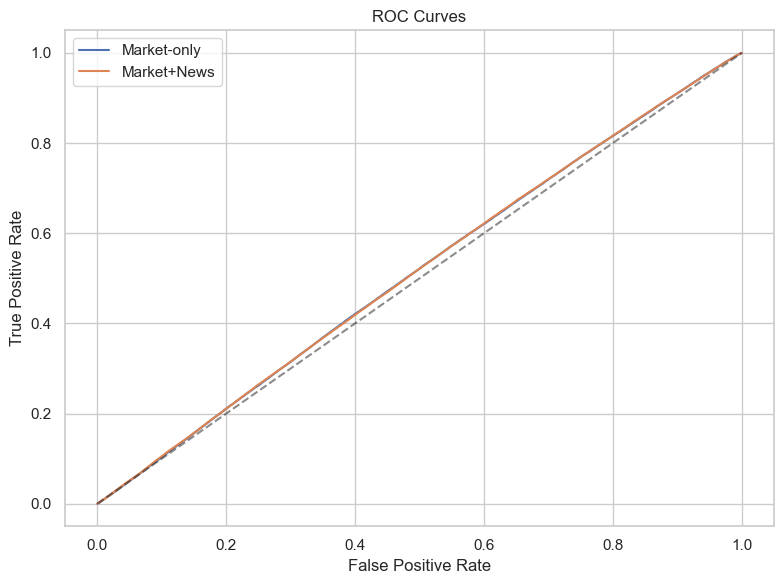


Top features by RandomForest importance:
vol_10               0.270409
vol_5                0.269994
ret_1_lag1           0.269179
avg_text_len         0.088801
ma_5                 0.030877
news_count           0.029684
ma_10                0.024415
unique_publishers    0.016640
dtype: float64


In [20]:
# Compare models: Market-only vs Market+News (time-ordered split, baseline classifiers)
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Safety check
if 'merged_with_news' not in globals():
    raise RuntimeError('`merged_with_news` not found - run previous cells to produce it')

# Prepare feature dataframe with technical features and news features
df = merged_with_news.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['ticker','date']).reset_index(drop=True)

# Compute per-ticker returns and lagged features
df['ret_1'] = df.groupby('ticker')['close'].pct_change()
df['ret_1_lag1'] = df.groupby('ticker')['ret_1'].shift(1)
df['ma_5'] = df.groupby('ticker')['close'].transform(lambda x: x.rolling(5).mean())
df['ma_10'] = df.groupby('ticker')['close'].transform(lambda x: x.rolling(10).mean())
df['vol_5'] = df.groupby('ticker')['ret_1'].transform(lambda x: x.rolling(5).std())
df['vol_10'] = df.groupby('ticker')['ret_1'].transform(lambda x: x.rolling(10).std())

# Use existing label 'future_direction_1' if present, else derive from future_return_1
if 'future_direction_1' not in df.columns and 'future_return_1' in df.columns:
    df['future_direction_1'] = (df['future_return_1'] > 0).astype(int)
elif 'future_direction_1' not in df.columns:
    raise RuntimeError('No future label found. Run earlier cell that adds future labels.')

# Fill news-derived features if missing
for col in ['news_count','unique_publishers','avg_text_len','combined_text']:
    if col not in df.columns:
        if col == 'combined_text':
            df[col] = ''
        else:
            df[col] = 0

# Feature lists
market_features = ['ret_1_lag1','ma_5','ma_10','vol_5','vol_10']
news_numeric = ['news_count','unique_publishers','avg_text_len']
text_col = 'combined_text'

# Drop rows with NaNs in feature columns or label
feats = market_features + news_numeric + [text_col]
keep_cols = feats + ['future_direction_1','date','ticker'] + ['close']
df_feat = df[keep_cols].copy()
df_feat = df_feat.dropna(subset=market_features + ['future_direction_1'])
df_feat = df_feat.reset_index(drop=True)
print('Prepared feature dataframe rows:', len(df_feat))

# Time-ordered train/test split by date (e.g., 70% train by time)
cutoff = df_feat['date'].quantile(0.7)
train = df_feat[df_feat['date'] <= cutoff].copy()
test = df_feat[df_feat['date'] > cutoff].copy()
print('Train rows:', len(train), 'Test rows:', len(test))

# Prepare X/y for two experiments: market-only and market+news (numeric only)
X_train_market = train[market_features].fillna(0)
X_test_market = test[market_features].fillna(0)
y_train = train['future_direction_1']
y_test = test['future_direction_1']

X_train_news = pd.concat([X_train_market, train[news_numeric].fillna(0)], axis=1)
X_test_news = pd.concat([X_test_market, test[news_numeric].fillna(0)], axis=1)

# Standardize numeric features
scaler = StandardScaler()
X_train_market_scaled = scaler.fit_transform(X_train_market)
X_test_market_scaled = scaler.transform(X_test_market)
X_train_news_scaled = scaler.fit_transform(X_train_news)
X_test_news_scaled = scaler.transform(X_test_news)

# Train baseline classifiers (Logistic Regression)
clf_market = LogisticRegression(max_iter=1000)
clf_news = LogisticRegression(max_iter=1000)
clf_market.fit(X_train_market_scaled, y_train)
clf_news.fit(X_train_news_scaled, y_train)

# Predict and evaluate helper
def eval_model(clf, X_test, y_test, label):
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1] if hasattr(clf,'predict_proba') else clf.decision_function(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_test, y_proba)
    except Exception:
        auc = float('nan')
    print(f"--- {label} ---")
    print('Accuracy:', round(acc,4))
    print('Precision:', round(prec,4))
    print('Recall:', round(rec,4))
    print('F1:', round(f1,4))
    print('ROC AUC:', round(auc,4))
    return y_test, y_proba, y_pred

# Evaluate both models
y_test_mkt, proba_mkt, pred_mkt = eval_model(clf_market, X_test_market_scaled, y_test, 'Market-only (LogReg)')
y_test_news, proba_news, pred_news = eval_model(clf_news, X_test_news_scaled, y_test, 'Market+News (LogReg)')

# Plot ROC curves
plt.figure(figsize=(8,6))
fpr_m, tpr_m, _ = roc_curve(y_test_mkt, proba_mkt)
fpr_n, tpr_n, _ = roc_curve(y_test_news, proba_news)
plt.plot(fpr_m, tpr_m, label='Market-only')
plt.plot(fpr_n, tpr_n, label='Market+News')
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.tight_layout()
plt.show()

include_text = False
if include_text:
    print('Building TF-IDF + SVD features from combined_text (this may take a while)')
    tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
    svd = TruncatedSVD(n_components=50, random_state=42)
    # Fit on train text
    X_train_text = train[text_col].fillna('').astype(str)
    X_test_text = test[text_col].fillna('').astype(str)
    X_train_tfidf = tfidf.fit_transform(X_train_text)
    X_test_tfidf = tfidf.transform(X_test_text)
    X_train_svd = svd.fit_transform(X_train_tfidf)
    X_test_svd = svd.transform(X_test_tfidf)
    # concatenate with numeric news+market features
    X_train_news_text = np.hstack([X_train_news_scaled, X_train_svd])
    X_test_news_text = np.hstack([X_test_news_scaled, X_test_svd])
    clf_news_text = LogisticRegression(max_iter=1000)
    clf_news_text.fit(X_train_news_text, y_train)
    _ = eval_model(clf_news_text, X_test_news_text, y_test, 'Market+News+Text (LogReg)')
    # ROC for text model
    y_test_text, proba_text, _ = y_test, clf_news_text.predict_proba(X_test_news_text)[:,1], None
    fpr_t, tpr_t, _ = roc_curve(y_test_text, proba_text)
    plt.figure(figsize=(8,6))
    plt.plot(fpr_m, tpr_m, label='Market-only')
    plt.plot(fpr_n, tpr_n, label='Market+News')
    plt.plot(fpr_t, tpr_t, label='Market+News+Text')
    plt.plot([0,1],[0,1],'k--',alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (with text)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Quick feature importance check with RandomForest on market+news numeric features
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_news_scaled, y_train)
importances = pd.Series(rf.feature_importances_, index=X_train_news.columns)
print('\nTop features by RandomForest importance:')
print(importances.sort_values(ascending=False).head(15))

In [21]:
# Convert news text to FinBERT embeddings and prepare data for a Temporal Fusion model
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from tqdm.auto import tqdm
import torch
from transformers import AutoTokenizer, AutoModel

if 'news_by_day' not in globals():
    # fallback: build news_by_day from merged_with_news if available
    if 'merged_with_news' in globals():
        news_by_day = merged_with_news[['date','ticker','combined_text']].drop_duplicates().rename(columns={'combined_text':'combined_text'})
    else:
        raise RuntimeError('news_by_day or merged_with_news not found. Run prior cells first.')

# Use Hugging Face FinBERT (ProsusAI/finbert) to create embeddings.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

# load model/tokenizer (may take a while on first run)
MODEL_NAME = 'ProsusAI/finbert'  # RoBERTa-based FinBERT
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)
model.eval()

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state  # (batch_size, seq_len, hidden_size)
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def embed_texts(texts, batch_size=32, max_length=128):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
        enc = {k:v.to(device) for k,v in enc.items()}
        with torch.no_grad():
            out = model(**enc)
        pooled = mean_pooling(out, enc['attention_mask'])
        emb = pooled.cpu().numpy()
        embeddings.append(emb)
    embeddings = np.vstack(embeddings)
    return embeddings

# Prepare text list (ensure deterministic order)
news_by_day = news_by_day.copy()
news_by_day['date'] = pd.to_datetime(news_by_day['date'])
news_by_day = news_by_day.sort_values(['ticker','date']).reset_index(drop=True)
texts = news_by_day['combined_text'].fillna('').astype(str).tolist()
print('Number of day-level news items to embed:', len(texts))

# Compute embeddings in batches and cache to disk for re-use
EMB_DIR = 'data/embeddings'
os.makedirs(EMB_DIR, exist_ok=True)
emb_path = os.path.join(EMB_DIR, 'finbert_embeddings.npy')
if os.path.exists(emb_path):
    print('Loading cached embeddings from', emb_path)
    all_embeddings = np.load(emb_path)
    if all_embeddings.shape[0] != len(texts):
        print('Cached embeddings length mismatch - recomputing')
        all_embeddings = embed_texts(texts, batch_size=32)
        np.save(emb_path, all_embeddings)
else:
    all_embeddings = embed_texts(texts, batch_size=32)
    np.save(emb_path, all_embeddings)
print('Embeddings shape:', all_embeddings.shape)

# Dimensionality reduction (TruncatedSVD) to get compact features for modeling
REDUCED_DIM = 32
svd_path = os.path.join(EMB_DIR, f'finbert_svd_{REDUCED_DIM}.pkl')
from joblib import dump, load
if os.path.exists(svd_path):
    svd = load(svd_path)
    reduced = svd.transform(all_embeddings)
else:
    svd = TruncatedSVD(n_components=REDUCED_DIM, random_state=42)
    reduced = svd.fit_transform(all_embeddings)
    dump(svd, svd_path)
print('Reduced embeddings shape:', reduced.shape)

# Attach reduced embeddings back to news_by_day
emb_cols = [f'emb_{i}' for i in range(reduced.shape[1])]
emb_df = pd.DataFrame(reduced, columns=emb_cols)
news_emb = pd.concat([news_by_day.reset_index(drop=True), emb_df], axis=1)

# Save small sample / cache
news_emb.to_parquet(os.path.join(EMB_DIR,'news_by_day_with_emb.parquet'), index=False)
print('Saved news embeddings to', EMB_DIR)

# Merge embeddings into merged_with_news on (ticker, date) to create time-varying embedding features
if 'merged_with_news' not in globals():
    raise RuntimeError('merged_with_news not found; run merge cell first')
merged_with_news = merged_with_news.copy()
merged_with_news['date'] = pd.to_datetime(merged_with_news['date'])
# perform left merge; news_emb date column is datetime date (may include time 00:00:00)
merged_with_news = merged_with_news.merge(news_emb[['ticker','date']+emb_cols], on=['ticker','date'], how='left')
# fill missing embeddings with zeros (no news that day)
merged_with_news[emb_cols] = merged_with_news[emb_cols].fillna(0.0)
print('Merged embeddings; resulting shape:', merged_with_news.shape)

Using device: cuda
Number of day-level news items to embed: 1053371
Loading cached embeddings from data/embeddings\finbert_embeddings.npy
Embeddings shape: (1053371, 768)
Reduced embeddings shape: (1053371, 32)
Saved news embeddings to data/embeddings
Merged embeddings; resulting shape: (1053371, 47)


In [22]:
from utils_topn import get_top_n_by_history, get_top_n_by_news

print('Testing top-N helpers')

top_n = 1000

# 1) top by history (using merged_with_news if available)
if 'merged_with_news' in globals():
    hist_subset, hist_top = get_top_n_by_history(merged_with_news, n=top_n)
    print(f'Top {top_n} tickers by history (length):', hist_top)
    print(hist_subset.groupby('ticker').size().sort_values(ascending=False).head())
else:
    print('merged_with_news not found in the notebook environment; run the pipeline cell first.')

# 2) top by news volume
if 'merged_with_news' in globals():
    news_subset, news_top, news_totals = get_top_n_by_news(merged_with_news, n=top_n)
    print(f'Top {top_n} tickers by news-volume: j', news_top)
    # print(news_totals.head())
else:
    print('No news DataFrame found (combined_news or news_by_day).')

top_n_news_df = merged_with_news[merged_with_news['ticker'].isin(news_top)]
print(top_n_news_df['ticker'])

Testing top-N helpers
Top 1000 tickers by history (length): ['KR', 'FCX', 'PBR', 'BLK', 'MDT', 'WDC', 'CI', 'MRK', 'JWN', 'GILD', 'BSX', 'TJX', 'DUK', 'CSX', 'OXY', 'EA', 'AXP', 'HD', 'TXN', 'MET', 'ALK', 'MS', 'HAL', 'KO', 'KSS', 'GME', 'FDX', 'SIRI', 'LEN', 'AEO', 'TSN', 'MRO', 'MAR', 'D', 'NSC', 'DAL', 'BAX', 'JNJ', 'LLY', 'STZ', 'DFS', 'CME', 'MT', 'TRV', 'NDAQ', 'SAVE', 'M', 'SYK', 'BMY', 'RF', 'KMB', 'VZ', 'WMB', 'BUD', 'NTAP', 'REGN', 'HUM', 'COF', 'SLB', 'GOLD', 'TSM', 'HP', 'WEN', 'RRC', 'BDX', 'QCOM', 'EW', 'CLX', 'ED', 'CP', 'BX', 'KGC', 'GRPN', 'TM', 'LMT', 'DBC', 'CSIQ', 'MU', 'CAG', 'HMC', 'PPG', 'IP', 'PRU', 'CF', 'GLD', 'ICE', 'NVDA', 'RL', 'WFC', 'LOW', 'PANW', 'TAP', 'SLV', 'KEY', 'EBAY', 'CLF', 'BEN', 'VTR', 'AFL', 'ILMN', 'MA', 'TRP', 'EOG', 'AVGO', 'PEP', 'AU', 'PAA', 'DLR', 'NTES', 'CNI', 'JD', 'NOK', 'DHI', 'ULTA', 'NVS', 'PRGO', 'DPZ', 'CNC', 'NOV', 'CTSH', 'SWN', 'IVZ', 'PCG', 'QQQ', 'BHP', 'E', 'KKR', 'TROW', 'DB', 'SU', 'STLD', 'NEM', 'DD', 'LYB', 'JCI', 'AA'

In [23]:
# Sanity checks before preparing TimeSeriesDataSet
def sanity_checks_before_TimeSeriesDataset(merged_with_news):
    print('*** Sanity check: merged_with_news overview ***')
    print('rows:', len(merged_with_news))
    print('columns:', merged_with_news.columns.tolist())
    print('date range:', pd.to_datetime(merged_with_news['date']).min(), '->', pd.to_datetime(merged_with_news['date']).max())
    if 'time_idx' in merged_with_news.columns:
        print('time_idx min/max:', merged_with_news['time_idx'].min(), merged_with_news['time_idx'].max())
    else:
        print('time_idx not present yet')
    # Key column non-null counts
    for col in ['ticker','date','time_idx','close','ret_1','news_count']:
        if col in merged_with_news.columns:
            print(col, 'non-null count:', merged_with_news[col].notna().sum())
        else:
            print(col, 'MISSING')
    # Groups size distribution
    try:
        gs = merged_with_news.groupby('ticker').size()
        print('Per-ticker group sizes: min', int(gs.min()), 'median', int(gs.median()), 'max', int(gs.max()))
    except Exception as e:
        print('Could not compute group sizes:', e)
    # Check training cutoff and training_df emptiness
    if 'time_idx' in merged_with_news.columns:
        training_cutoff = int(merged_with_news['time_idx'].quantile(0.7))
        training_df = merged_with_news[merged_with_news.time_idx <= training_cutoff]
        print('training_cutoff:', training_cutoff, 'training rows:', len(training_df))
        if len(training_df) == 0:
            raise RuntimeError('Training dataframe empty after cutoff; adjust cutoff or ensure data has sufficient history')
    # Embedding sparsity check (if embeddings exist)
    emb_cols = [c for c in merged_with_news.columns if str(c).startswith('emb_')]
    if len(emb_cols) > 0:
        frac_zero = (merged_with_news[emb_cols].abs().sum(axis=1) == 0).mean()
        print(f'Fraction of rows with all-zero embeddings: {frac_zero:.3f}')
    else:
        print('No embedding columns present')
sanity_checks_before_TimeSeriesDataset(top_n_news_df)

*** Sanity check: merged_with_news overview ***
rows: 726775
columns: ['date', 'ticker', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits', 'news_count', 'unique_publishers', 'avg_text_len', 'combined_text', 'future_return_1', 'future_direction_1', 'emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4', 'emb_5', 'emb_6', 'emb_7', 'emb_8', 'emb_9', 'emb_10', 'emb_11', 'emb_12', 'emb_13', 'emb_14', 'emb_15', 'emb_16', 'emb_17', 'emb_18', 'emb_19', 'emb_20', 'emb_21', 'emb_22', 'emb_23', 'emb_24', 'emb_25', 'emb_26', 'emb_27', 'emb_28', 'emb_29', 'emb_30', 'emb_31']
date range: 2009-04-29 00:00:00 -> 2024-09-26 00:00:00
time_idx not present yet
ticker non-null count: 726775
date non-null count: 726775
time_idx MISSING
close non-null count: 726775
ret_1 MISSING
news_count non-null count: 726775
Per-ticker group sizes: min 1 median 677 max 1809
Fraction of rows with all-zero embeddings: 0.000


In [24]:
# Save merged dataset with embeddings (optional)
out_path = 'data/top_n_news_df_and_emb.parquet'
top_n_news_df.to_parquet(out_path, index=False)
print('Saved merged dataset with embeddings to', out_path)

Saved merged dataset with embeddings to data/top_n_news_df_and_emb.parquet


In [25]:
import pandas as pd
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [26]:
# Load prestored top_n_news_df if not present in globals()
top_n_news_df = pd.read_parquet(r"data\top_n_news_df_and_emb.parquet")
len(top_n_news_df.columns)

47

In [28]:
# Prepare dataset for Temporal Fusion Transformer (pytorch-forecasting)
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
import numpy as _np


# Basic checks and robust handling if embeddings were not created
if 'top_n_news_df' not in globals():
    raise RuntimeError('`top_n_news_df` not found; run the merge cell first')

# ensure date column is datetime
top_n_news_df['date'] = pd.to_datetime(top_n_news_df['date'])
# create time_idx: days since global min date (or per-ticker time can be used)
top_n_news_df = top_n_news_df.sort_values(['ticker','date']).reset_index(drop=True)
global_start = top_n_news_df['date'].min()
top_n_news_df['time_idx'] = (top_n_news_df['date'] - global_start).dt.days.astype(int)

# ensure basic derived features exist (compute if missing).
# 'close' must exist from the merged prices; 'ret_1' is pct change of close per ticker.
if 'close' not in top_n_news_df.columns:
    raise RuntimeError("'close' column not found in `top_n_news_df`; ensure stock data was merged correctly")
if 'ret_1' not in top_n_news_df.columns:
    top_n_news_df['ret_1'] = top_n_news_df.groupby('ticker')['close'].pct_change()
    top_n_news_df['ret_1'] = top_n_news_df['ret_1'].fillna(0.0)

# detect embedding columns (if any). If embeddings were not produced, continue with empty list
emb_cols = [c for c in top_n_news_df.columns if str(c).startswith('emb_')]
if len(emb_cols) == 0:
    print('No embedding columns (emb_*) found in `top_n_news_df`. Proceeding without embeddings.')
else:
    print('Found', len(emb_cols), 'embedding columns')

# choose target and static/time-varying features
target = 'future_return_1'
if target not in top_n_news_df.columns:
    if 'future_direction_1' in top_n_news_df.columns:
        print(f'{target} not found — falling back to binary label `future_direction_1` for TFT target')
        target = 'future_direction_1'
    else:
        raise RuntimeError('No suitable target found in `top_n_news_df` (expected future_return_1 or future_direction_1)')

static_categoricals = []
static_reals = []
time_varying_known_reals = ['news_count','unique_publishers','avg_text_len'] + emb_cols
time_varying_unknown_reals = ['close','ret_1']  # values that will be predicted or are not known far ahead

# define training dataset window sizes
max_encoder_length = 60  # history length the model sees
max_prediction_length = 1  # forecast horizon

if TimeSeriesDataSet is not None:
    training_cutoff = int(top_n_news_df['time_idx'].quantile(0.7))
    training_df = top_n_news_df[top_n_news_df.time_idx <= training_cutoff]
    print('Training dataframe rows (pre-clean):', len(training_df))
    training_df = training_df.replace([_np.inf, -_np.inf], _np.nan)
    training_df = training_df.dropna(subset=[target])
    print('Training dataframe rows (after dropping NaN/inf target):', len(training_df))

    merged_clean = top_n_news_df.replace([_np.inf, -_np.inf], _np.nan).dropna(subset=[target])

    training = TimeSeriesDataSet(
        training_df,
        time_idx='time_idx',
        target=target,
        group_ids=['ticker'],
        min_encoder_length=30,
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=static_categoricals,
        static_reals=static_reals,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        allow_missing_timesteps=True,
        target_normalizer=None,
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )
    print('Prepared TimeSeriesDataSet for training with', len(training), 'samples')
    # create validation dataset (example) using cleaned merged frame
    validation = TimeSeriesDataSet.from_dataset(training, merged_clean, predict=True, stop_randomization=True)
    print('Prepared validation dataset with', len(validation), 'samples')
else:
    print('TimeSeriesDataSet unavailable; data prepared in `top_n_news_df`. Embedding columns (if any):', emb_cols)


Found 32 embedding columns
Training dataframe rows (pre-clean): 508742
Training dataframe rows (after dropping NaN/inf target): 508742
Prepared TimeSeriesDataSet for training with 747713 samples


d:\Anki\Masters\UMICH\Course Docs\Fall 2025\STATS507\project\venv\Lib\site-packages\pytorch_forecasting\data\timeseries\_timeseries.py:1850: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 37 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__ticker': 'ACT'}, {'__group_id__ticker': 'AI'}, {'__group_id__ticker': 'ARRY'}, {'__group_id__ticker': 'BAM'}, {'__group_id__ticker': 'BNO'}, {'__group_id__ticker': 'CHK'}, {'__group_id__ticker': 'CHN'}, {'__group_id__ticker': 'CLDT'}, {'__group_id__ticker': 'CR'}, {'__group_id__ticker': 'CRC'}]
  warnings.warn(


Prepared validation dataset with 963 samples


In [ ]:
# Train a Temporal Fusion Transformer and evaluate on test data
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch import Trainer
import torch

# dataloaders
train_dataloader = training.to_dataloader(train=True, batch_size=256, num_workers=4)
val_dataloader = validation.to_dataloader(train=False, batch_size=256, num_workers=4)

# model setup (quantile outputs: 0.1, 0.5, 0.9 -> median at index 1)
quantiles = [0.1, 0.5, 0.9]
loss = QuantileLoss(quantiles)
model = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=len(quantiles),
    loss=loss,
    reduce_on_plateau_patience=4,
)

# callbacks and trainer
early_stop = EarlyStopping(monitor="val_loss", patience=3, mode="min")
checkpoint_callback = ModelCheckpoint(dirpath="models", filename="tft-{epoch}-{val_loss:.4f}", save_top_k=1, monitor="val_loss", mode="min")

gpu_available = torch.cuda.is_available()
trainer_kwargs = {"max_epochs": 5, "callbacks": [early_stop, checkpoint_callback]}
if gpu_available:
    trainer_kwargs.update({"accelerator": "gpu", "devices": 1})
else:
    trainer_kwargs.update({"accelerator": "cpu", "devices": 1})

trainer = Trainer(**trainer_kwargs)

# fit
trainer.fit(model, train_dataloader, val_dataloader)

# Prepare test dataset from the cleaned merged frame (merged_clean exists from previous cell)
if 'merged_clean' not in globals():
    merged_clean = merged_with_news.replace([float('inf'), float('-inf')], pd.NA).dropna(subset=[target])

# test split
test_df = merged_clean[merged_clean.time_idx > training_cutoff]
print('Test rows:', len(test_df))
if len(test_df) == 0:
    raise RuntimeError('No test rows found after training cutoff; adjust split or check data')

test = TimeSeriesDataSet.from_dataset(training, test_df, predict=True, stop_randomization=True)
test_dataloader = test.to_dataloader(train=False, batch_size=128, num_workers=4)

# predict
print('Running predictions on test set (this may take a while)')
preds = model.predict(test_dataloader)
import numpy as np
pred_array = np.array(preds)
if pred_array.ndim == 3:
    pred_array = pred_array.reshape(-1, pred_array.shape[-1])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode  | FLOPs
--------------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train | 0    
1  | logging_metrics                    | ModuleList                      | 0      | train | 0    
2  | input_embeddings                   | MultiEmbedding                  | 0      | train | 0    
3  | prescalers                         | ModuleDict                      | 1.3 K  | train | 0    
4  | static_variable_selection          | VariableSelectionNetwork        | 9.4 K  | train | 0    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 146 K  | train | 0 

Epoch 0:  30%|███       | 879/2920 [05:44<13:20,  2.55it/s, v_num=8, train_loss_step=0.0105] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

In [ ]:
from pytorch_forecasting import TemporalFusionTransformer

import glob, os
ckpts = sorted(glob.glob('models/*.ckpt'), key=os.path.getmtime)
if not ckpts:
    print('No checkpoints found in models/. If you want to retrain, run the training cell.')
else:
    best_ckpt = ckpts[-1]
    print('Loading checkpoint:', best_ckpt)
    device ='cpu'
    # load the full checkpoint (weights_only=False) because the checkpoint contains custom objects
    model = TemporalFusionTransformer.load_from_checkpoint(best_ckpt, map_location=device, weights_only=False)
    model.eval()

batch = next(iter(train_dataloader))
example_x, example_y = batch
print(example_x,example_y)
example_x_cpu = {k: v.to("cpu") for k, v in example_x.items()}

import torch

scripted_model = torch.jit.trace(model, example_x)
jit_path = "models/tft_scripted.pt"
scripted_model.save(jit_path)

print("Saved TorchScript model to:", jit_path)

In [ ]:
# Evaluate a saved best checkpoint (avoid retraining)
import glob, os
from pytorch_forecasting import TemporalFusionTransformer

ckpts = sorted(glob.glob('models/*.ckpt'), key=os.path.getmtime)
if not ckpts:
    print('No checkpoints found in models/. If you want to retrain, run the training cell.')
else:
    best_ckpt = ckpts[-1]
    print('Loading checkpoint:', best_ckpt)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # load the full checkpoint (weights_only=False) because the checkpoint contains custom objects
    model_ckpt = TemporalFusionTransformer.load_from_checkpoint(best_ckpt, map_location=device, weights_only=False)
    # Prepare test dataloader (reuse prior test_df if present)
    if 'training' not in globals():
        raise RuntimeError('`training` TimeSeriesDataSet not found in notebook environment; run dataset prep cell first')
    if 'merged_clean' not in globals():
        merged_clean = merged_with_news.replace([float('inf'), float('-inf')], pd.NA).dropna(subset=[target])
    test_df = merged_clean[merged_clean.time_idx > training_cutoff]
    test = TimeSeriesDataSet.from_dataset(training, test_df, predict=True, stop_randomization=True)
    test_dataloader = test.to_dataloader(train=False, batch_size=128, num_workers=4)
    print('Running predictions using checkpoint...')
    preds = model_ckpt.predict(test_dataloader)
    import numpy as np
    pred_array = np.array(preds)
    if pred_array.ndim == 3:
        pred_array = pred_array.reshape(-1, pred_array.shape[-1])
    median_idx = 1 if pred_array.shape[1] > 1 else 0
    pred_median = pred_array[:, median_idx]
    y_true = test_df.sort_values(['ticker','time_idx']).reset_index(drop=True)[target].values[: len(pred_median)]
    from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
    mae = mean_absolute_error(y_true, pred_median)
    rmse = np.sqrt(mean_squared_error(y_true, pred_median))
    print(f'Checkpoint evaluation -> MAE: {mae:.6f}, RMSE: {rmse:.6f}')
    if 'future_direction_1' in test_df.columns:
        pred_dir = (pred_median > 0).astype(int)
        y_dir = test_df.sort_values(['ticker','time_idx']).reset_index(drop=True)['future_direction_1'].values[: len(pred_median)]
        acc = accuracy_score(y_dir, pred_dir)
        print(f'Directional accuracy: {acc:.4f}')
    print('Done')
